In [1]:
from stable_baselines3 import DQN
import torch

In [94]:
# model = DQN.load('../output_models/2021-06-18_16_57_43_15.zip')
# model.load_replay_buffer("../output_models/2021-06-18_16_57_43_15_rb")attributions

In [2]:
model = DQN.load('../best_model/dqn/MlpPolicy/best_model.zip')
model.load_replay_buffer("../best_model/dqn/MlpPolicy/best_model_rb")

/Users/amalota/anaconda3/envs/py37/lib/python3.7/site-packages/cloudpickle/cloudpickle.py:704: UserWarning: A pickle file created using an old (<=1.4.1) version of cloudpicke is currently being loaded. This is not supported by cloudpickle and will break in cloudpickle 1.7
  "will break in cloudpickle 1.7", category=UserWarning


In [3]:
net = model.q_net
net.eval()

QNetwork(
  (features_extractor): FlattenExtractor(
    (flatten): Flatten(start_dim=1, end_dim=-1)
  )
  (q_net): Sequential(
    (0): Linear(in_features=7, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=7, bias=True)
  )
)

In [4]:
model.replay_buffer.observations.shape

(1000000, 1, 7)

In [8]:
X = model.replay_buffer.observations[0:1000]
X = torch.Tensor(X)

In [9]:
X.sum()

tensor(50.9370)

In [10]:
X.shape

torch.Size([1000, 1, 7])

In [11]:
from captum.attr import IntegratedGradients
import numpy as np

feature_names = np.array([        
    "vmAllocatedRatioHistory",
        "avgCPUUtilizationHistory",
        "p90CPUUtilizationHistory",
        "avgMemoryUtilizationHistory",
        "p90MemoryUtilizationHistory",
        "waitingJobsRatioGlobalHistory",
        "waitingJobsRatioRecentHistory"])

action_names = ['ACTION_NOTHING',
'ACTION_ADD_SMALL_VM',
'ACTION_REMOVE_SMALL_VM',
'ACTION_ADD_MEDIUM_VM',
'ACTION_REMOVE_MEDIUM_VM',
'ACTION_ADD_LARGE_VM',
'ACTION_REMOVE_LARGE_VM',]

In [12]:
x_axis_data = np.arange(X.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X, n_steps=50, target=target) for target in range(len(action_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

In [13]:

ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

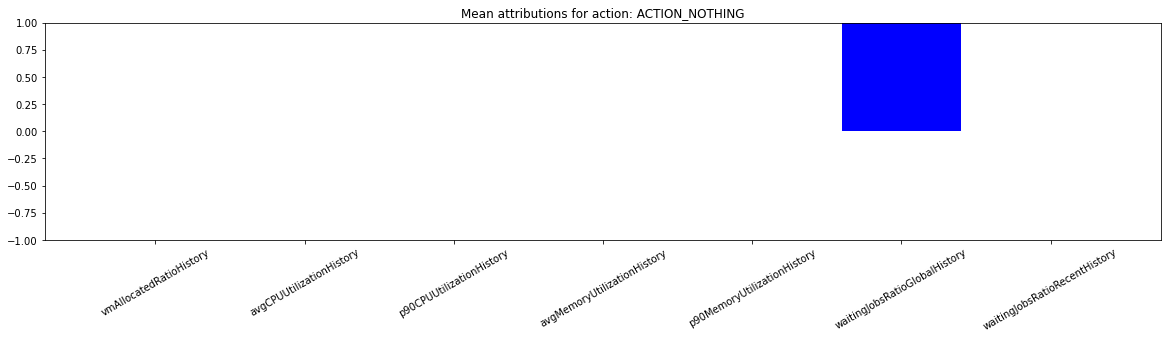

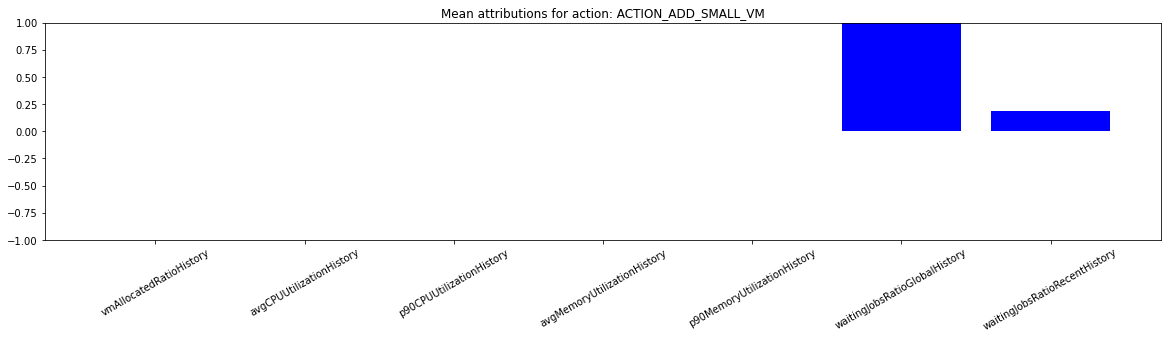

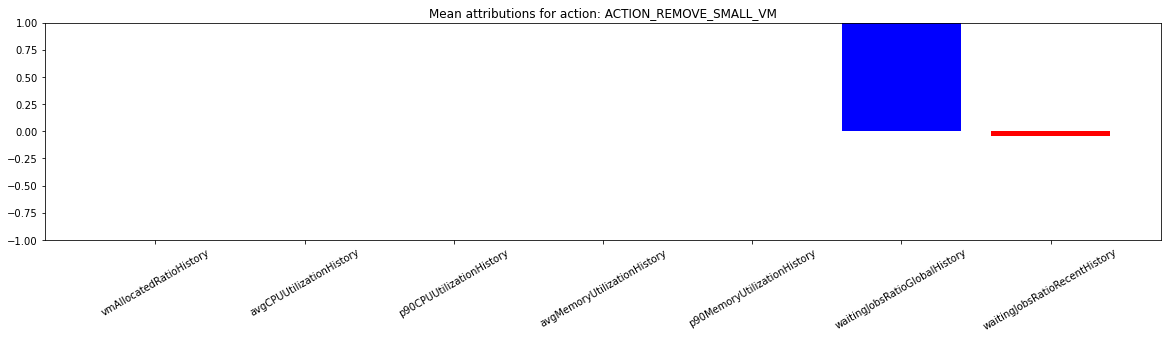

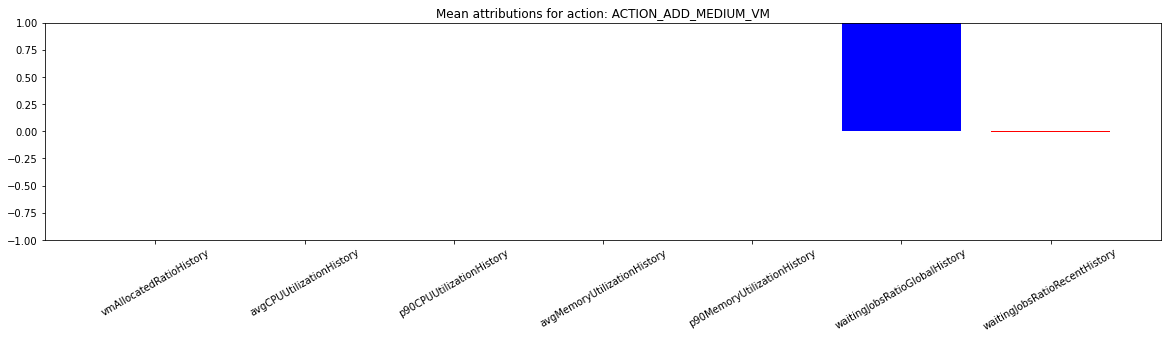

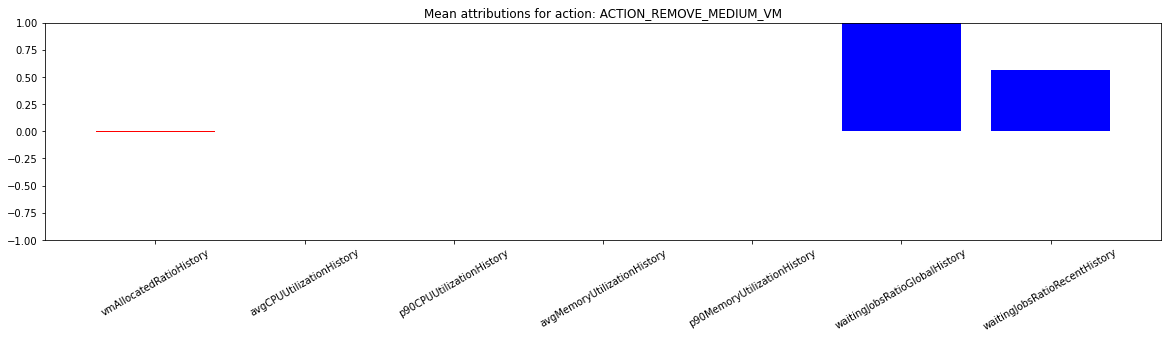

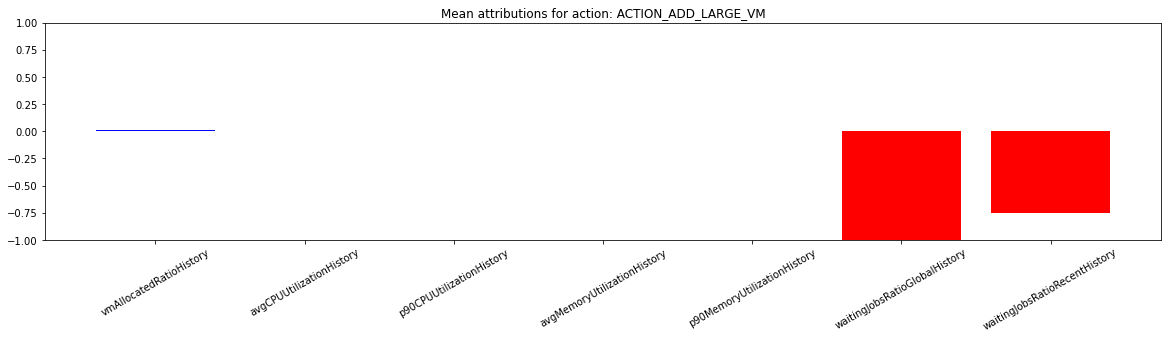

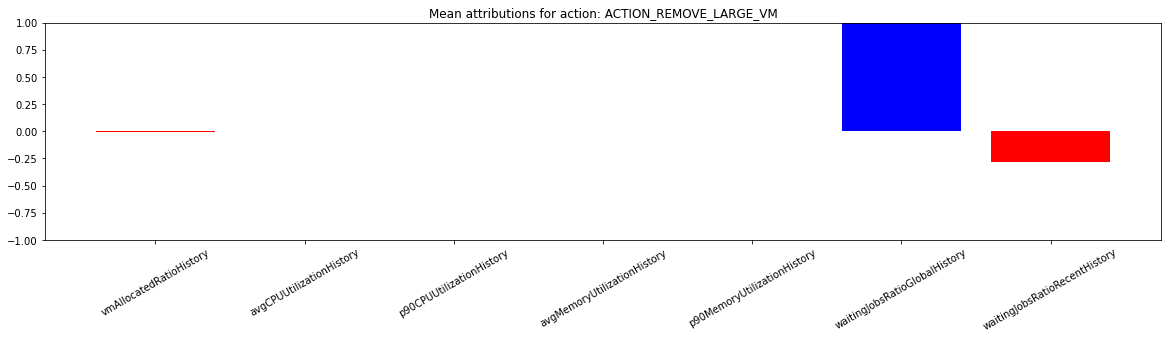

In [14]:
import matplotlib.pyplot as plt

for i, ig_attr in enumerate(ig_attr_test_norm_sum):
    plt.figure(figsize=(20, 4))
    plt.title(f'Mean attributions for action: {action_names[i]}')
    plt.xticks(x_axis_data, feature_names, rotation=30)
    plt.ylim([-1, 1])
    col = []
    for val in ig_attr[0]:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.bar(x_axis_data, ig_attr[0], color=col)

In [57]:
def render_env(img, feature_names):
    plt.figure(figsize=(20, 4))
    col = []
    for val in img:
        if val < 0.0:
            col.append('red')
        else:
            col.append('blue')
    plt.xticks(range(7), feature_names, rotation=30)
    plt.bar(range(7), img, color=col)
    plt.title('Environment state')
    plt.show()

In [58]:
def explain_action(idx, X, attributions, x_axis_data, feature_names, action_names, model, state=None):
    img = X[idx][0].numpy()
    q_values = model.q_net.forward(X[idx]).detach().numpy()
    action = np.argmax(q_values)
    
    print(f'Action made: {action_names[action]}')
    
    render_env(img=img,
           feature_names=feature_names)
    
    fig, axs = plt.subplots(len(attributions), 1, figsize=(20, 20), sharex=True)
    plt.xticks(x_axis_data, feature_names, rotation=30)
    for i, ig_attr in enumerate(attributions):
        axs[i].set_title(f'Attributions for action: {action_names[i]}')
        col = []
        ig_attr = ig_attr.numpy()[idx][0]
        for val in ig_attr:
            if val < 0.0:
                col.append('red')
            else:
                col.append('blue')
        axs[i].bar(x_axis_data, ig_attr, color=col)
    


Action: ACTION_ADD_MEDIUM_VM


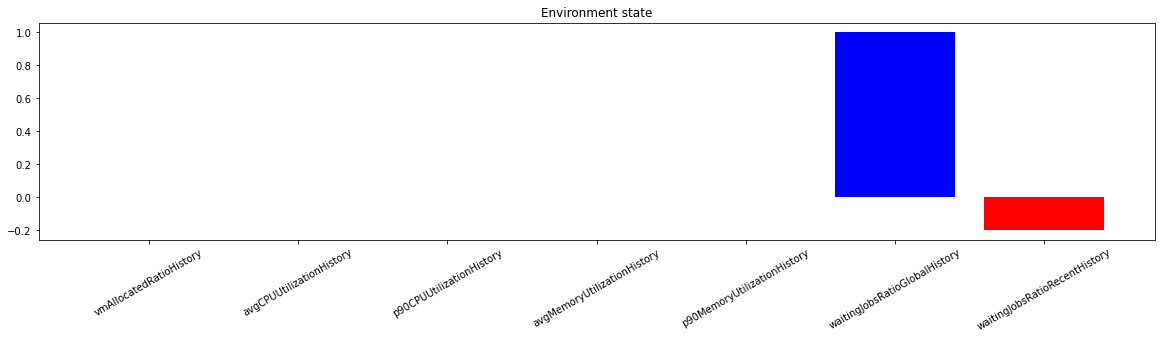

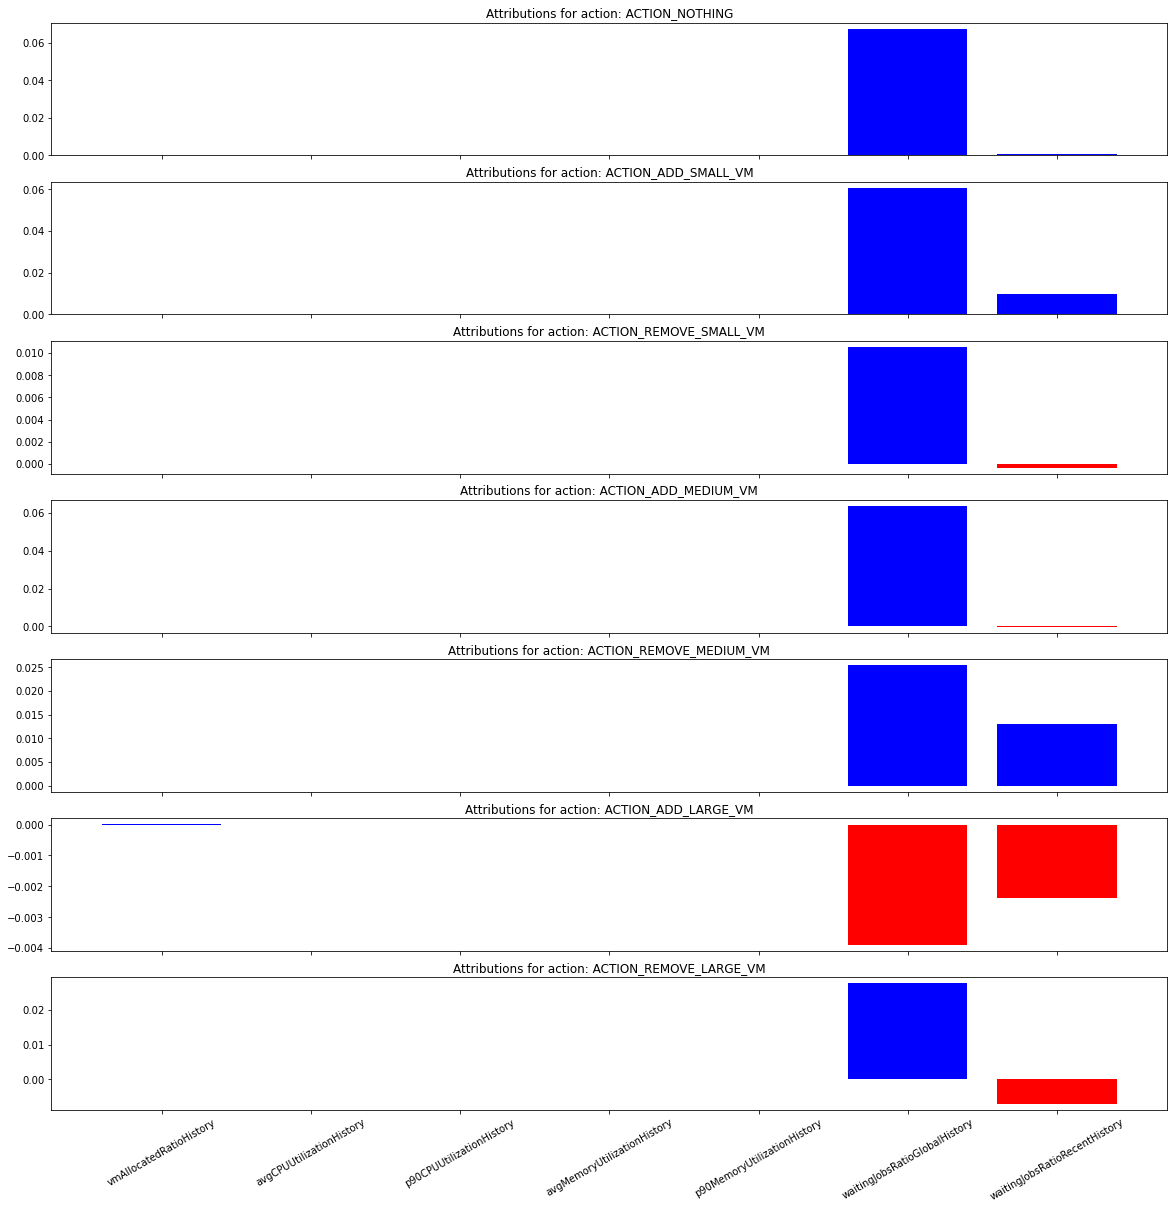

In [59]:
explain_action(idx=200,
               X=X,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )

In [51]:
X_manual = torch.Tensor([[[1, 1, 1, 1, 1, 1, 1]]])

In [52]:
X_manual.shape

torch.Size([1, 1, 7])

In [61]:
x_axis_data = np.arange(X_manual.shape[2])

ig = IntegratedGradients(net)

ig_attr_per_action = [ig.attribute(X_manual, n_steps=50, target=target) for target in range(len(action_names))]
ig_attr_test_norm_sum = [action_att.detach().numpy().sum(0) / np.linalg.norm(action_att.detach().numpy().sum(0), ord=1) for action_att in ig_attr_per_action]

Action: ACTION_REMOVE_MEDIUM_VM


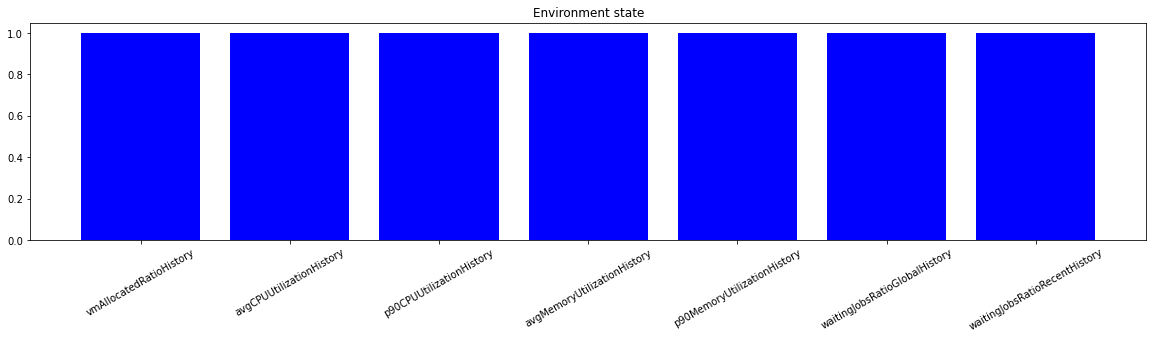

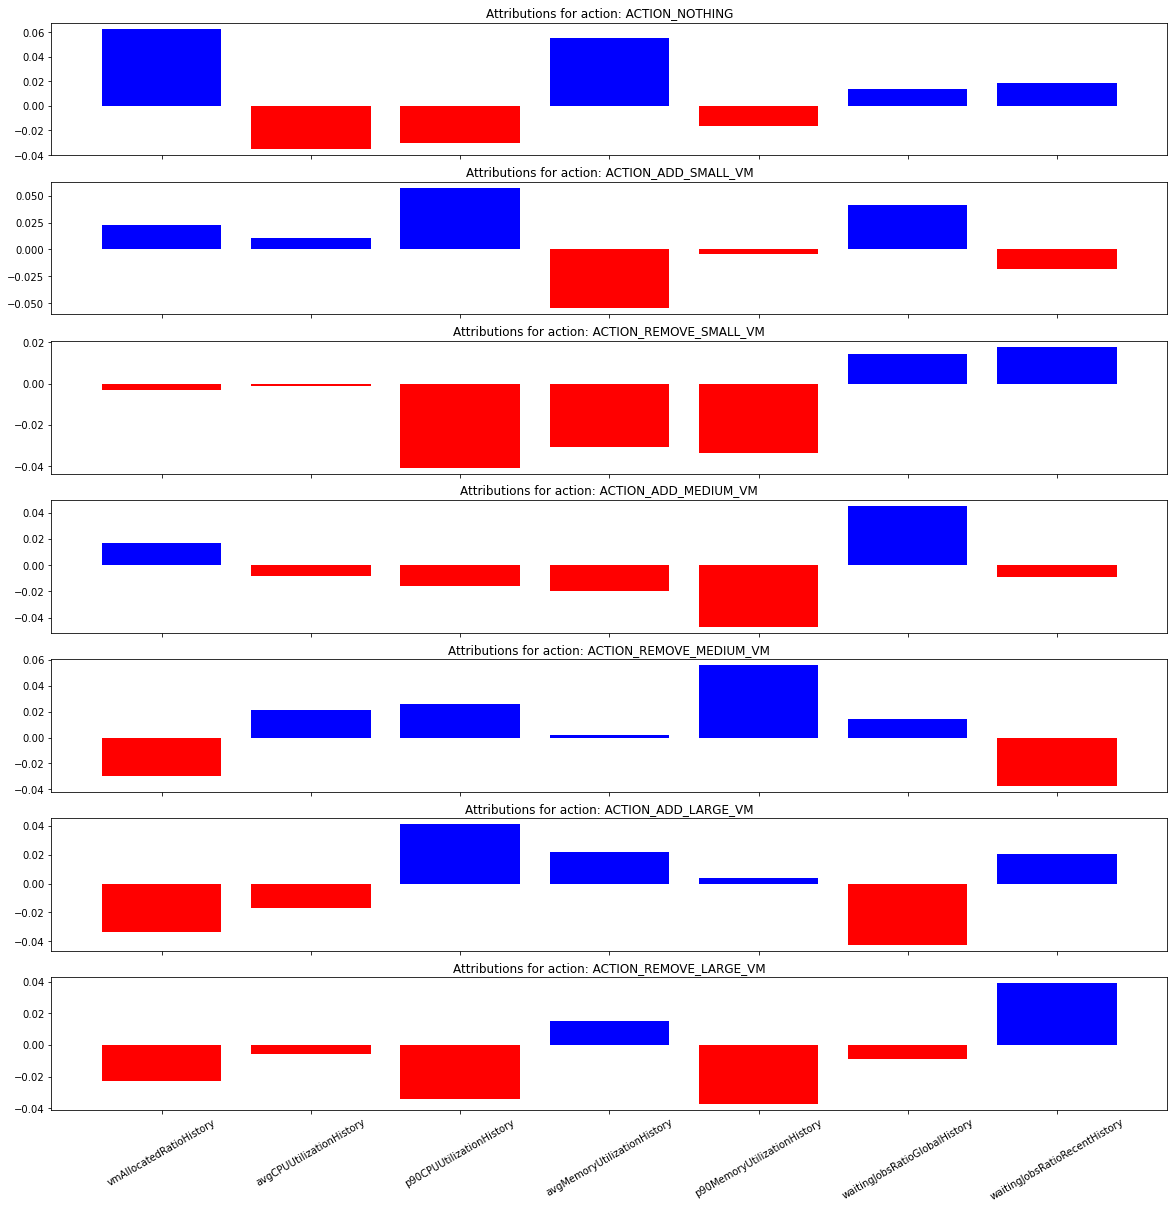

In [62]:
explain_action(idx=0,
               X=X_manual,
               attributions=ig_attr_per_action,
               x_axis_data=x_axis_data,
               feature_names=feature_names,
               action_names=action_names,
               model=model,
              )